# Parte 2: Funções Base e Regressão de Mínimos Quadrados Ordinários (OLS)

Esta parte do nosso Homework é a espinha dorsal da modelagem. Aqui, iremos discutir as funções de avaliação RMSE(`rmse`) e R²(`r2`), a função de validação cruzada (`cross_validate`) e a implementação do modelo base de Regressão de Mínimos Quadrados Ordinários (OLS) do zero, verificando e comparando usando funções prontas da biblioteca do `scikit-learn`.

O código completo das funções se encontra no arquivo `funcoes_base.py`

Vamos começar baixando nossos dados

In [152]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from pathlib import Path
sys.path.append
from funcoes_base import *

import pickle

with open("dados_preprocessados.pkl", "rb") as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

print("Dados pré-processados carregados!")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")


Dados pré-processados carregados!
X_train: (951, 192), X_test: (316, 192)


- **solTrainX.txt**: descritores químicos do conjunto de treino  
- **solTrainY.txt**: solubilidades reais de treino  
- **solTestX.txt**: descritores do teste  
- **solTestY.txt**: solubilidades reais do teste

In [153]:
# vendo as primeiras linhas
X_train.head()

,FP001,FP002,FP003,FP004,FP006,FP007,FP008,FP009,FP010,FP011,...,NumAtoms,NumNonHAtoms,NumMultBonds,NumRotBonds,NumDblBonds,NumHydrogen,NumOxygen,NumRings,HydrophilicFactor,SurfaceArea1
661,0,1,0,0,0,0,1,0,0,0,...,0.414490,0.618505,1.525830,-1.310081,-1.040966,0.132150,-1.223095,1.210831,-1.179557,0.054456
662,0,1,0,1,1,1,1,0,0,1,...,1.634618,1.662549,1.205733,0.956270,-1.040966,1.380068,-0.032956,1.623611,-0.058395,0.684493
663,1,1,1,1,0,0,1,0,1,0,...,0.767472,0.483492,0.398286,0.956270,0.436890,0.874351,0.600442,-0.074594,0.014455,0.363815
665,0,0,1,0,0,1,0,0,0,0,...,0.256793,-0.341823,-0.679854,-0.298924,1.063721,0.647034,-1.223095,-0.074594,-1.478528,-1.519432
668,0,0,1,1,1,0,0,1,0,0,...,0.632620,0.483492,0.228348,1.195466,-1.040966,0.647034,-1.223095,-0.074594,0.421494,0.718171


Descrições da quantidade:

In [154]:
print("Treino:", X_train.shape)
print("Teste:", X_test.shape)

print("\nNúmero de preditores:", X_train.shape[1])


Treino: (951, 192)
Teste: (316, 192)

Número de preditores: 192


O dataset de solubilidade contém 1.267 compostos químicos, cada um descrito por 228 preditores, sendo:

- 208 fingerprints binários

- 16 descritores de contagem

- 4 descritores contínuos

A variável resposta (Solubility) é contínua.

A divisão entre treino e teste é 951/316.

Mas a análise mais detalhada fizemos na primeira parte desse trabalho

Agora, vamos falar sobre as métricas que iremos usar nesse trabalho de maneira mais aprofundada. Implementamos elas no arquivo funcoes_base.py

## 1. Funções Universais

As funções de métrica e a função de validação cruzada (CV) foram criadas para serem **independentes**, garantindo que todos os modelos (OLS, ridge/lasso, PCR/PLS e redes neurais) usem as mesmas formas de avaliação, o que evita redundâncias nos nossos códigos.


### 1.1. Root Mean Squared Error (RMSE)

O RMSE é um tipo de métrica de erros, usado na etapa da validação. É o tipo mais popular usado em problemas de regressão, ele faz a raíz quadrada da média dos erros quadráticos e penaliza erros maiores (assim como o MSE que ao tirarmos a raíz dele, obtemos o RMSE). Aqui, o interesse está em quantificar a magnitude dos erros de previsão. O RMSE é preferido sobre o MSE porque preserva a unidade da variável resposta e penaliza erros grandes de forma mais pronunciada, característica útil quando lidamos com variáveis químicas contínuas, como solubilidade. Sua fórmula se dá por:

$$\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$


### 1.2. Coeficiente de Determinação (R²)

O $R^2$ (R-quadrado) indica a proporção da variância (que indica o grau de dispersão de um conjunto de dados em relação à sua média) na variável dependente que é previsível a partir das variáveis independentes. Um valor de 1.0 indica um ajuste perfeito.

Essa função vai receber os dois vetores, com os valores verdadeiros e os previstos e vai ser calculada usando a fórmula:

$$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$$

Onde:

| Componente | Nome | O que calcula | Significado |
| :--- | :--- | :--- | :--- |
| **$SS_{res}$** | **Soma dos Quadrados dos Resíduos** | `np.sum((y_real - y_pred)**2)` | Mede a variância **não explicada** pelo modelo. É o erro acumulado (distância) entre os valores reais ($y_{real}$) e as previsões do modelo ($y_{pred}$). |
| **$SS_{tot}$** | **Soma Total dos Quadrados** | `np.sum((y_real - np.mean(y_real))**2)` | Mede a **variância total** nos dados. É a distância dos valores reais ($y_{real}$) em relação à média ($\bar{y}$). Serve como a linha de base de comparação. |

### Interpretação do Resultado

| Valor $R^2$ | Interpretação |
| :--- | :--- |
| **Próximo de 1** | O modelo se ajusta muito bem aos dados; uma grande proporção da variância é explicada (Soma dos Quadrados dos Resíduos muito pequena em relação à Soma Total dos Quadrados ). |
| **Próximo de 0** | O modelo não é melhor do que simplesmente usar a média dos dados ($\bar{y}$) como previsão (Soma Total dos Quadrados muito igual à Soma dos Quadrados dos Resíduos). |

Exemplo: se $R^2 = 0.45$, significa que **45%** da variância nos dados de saída é explicada pelo seu modelo de regressão.


### 1.3. Cross-Validation (`cross_validate`)

Esta é uma função genérica que vai ajudar na hora do treinamento e validação. Ela vai separar os dados e chamar uma função com dados de treinamento e validação e calcular as métricas que falamos acima com essa previsão. Será usada nas partes 3 e 4. Ela vai ficar lidando com a parte de dividir os dados em folds sem se importar com o modelo (ridge/PCR/rede neural).

Em vez de testar o modelo apenas uma vez, ela divide os dados em $K$ partes (geralmente 5) e testa o modelo $K$ vezes, o que faz com que a avaliação não seja influenciada por uma divisão de dados azarenta.

Então, temos os parâmetros dessa validação cruzada os seguintes:

Parâmetro | Tipo | Descrição |
| :--- | :--- | :--- |
| `model_fn` | `function` | A **função de retorno** que encapsula o treinamento e a previsão do seu modelo específico. |
| `X` | `np.array` | O conjunto completo de *features*. |
| `y` | `np.array` | O conjunto completo de *targets*. |
| `k` | `int` | O número de *folds*. |

E assim, o loop central fica:

1.  **Divisão:** Em cada iteração (`i` de $k$), a função separa o conjunto de dados em duas partes:
    * **Conjunto de Validação (`X_val`, `y_val`):** A i-ésima fatia dos dados (1/K do total).
    * **Conjunto de Treinamento (`X_train`, `y_train`):** As fatias restantes (K-1)/K do total.
2.  **Execução do Modelo:** A função chama `y_pred = model_fn(X_train, y_train, X_val)`. É aqui que o modelo é treinado em `X_train` e gera previsões para `X_val`.
3.  **Avaliação:** As previsões (`y_pred`) são comparadas com os valores reais (`y_val`) para calcular o RMSE e o $R^2$ para o *fold* atual.
4.  **Resultado:** A função retorna a **média** das métricas obtidas em todos os $k$ *folds*.

Seu uso seria assim por exemplo:

`media_rmse, media_r2 = cross_validate(linear_model_fn, X_dados_completos, y_dados_completos, k=5)`

sendo o `linear_model_fn` um modelo treinado de regressão linear que retorna `y_pred`.

## 2. Implementação do OLS

O OLS (Ordinary Least Squares) é um modelo base que no nosso trabalho foi implementado do zero usando sua fórmula matricial. O objetivo da regressão linear OLS é achar o plano que minimiza a soma dos erros quadráticos (SSE) dada por: 

$$SSE =  \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

### 2.1. Fórmula Matricial

Os coeficientes $\beta$ (incluindo o intercepto) são calculados diretamente pela solução de forma fechada:

$$\boldsymbol{\beta} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}$$

Esses betas representam o plano otimizado que minimiza os erros quadráticos, ou seja, ele é um dos coeficientes que minimiza o erro para determinada feature. Por exemplo, um $X1$, seria uma matriz que contêm os valores de um determinado preditor $p1$, um $\beta 1$  representaria o coeficiente da forma de regressão linear que minimizaria os erros entre os valores reais e os valores preditos e $y$ seria o vetor de respostas

Esta lógica está encapsulada nas funções `fit_ols(X, y)` e `predict_ols(X, beta)` no arquivo `funcoes_base.py`.



## 3. Validação e Comparação de Resultados

Carregamos o arquivo `funcoes_base.py` e com isso obtemos alguns resultados. Este arquivo basicamente carrega o dataset, divide em treino e teste, executa a CV para o OLS manual e o OLS do `scikit-learn`.

Fazendo o treinamento do modelo OLS manualmente:

In [155]:
beta_manual = fit_ols(X_train , y_train)
y_pred_manual_test = predict_ols(X_test , beta_manual)

Agora fazendo o mesmo usando o scikit-learn, usando o modelo de regressão linear:

In [156]:
ols = LinearRegression()
ols.fit(X_train, y_train)
y_pred_sklearn_test = ols.predict(X_test)

Calculando as métricas:

### 3.1. Cálculo das Métricas com Dados de Teste

In [157]:
rmse_manual = rmse(y_test, y_pred_manual_test)
r2_manual   = r2(y_test, y_pred_manual_test)

rmse_sk     = rmse(y_test, y_pred_sklearn_test)
r2_sk       = r2(y_test, y_pred_sklearn_test)

tabela_test = pd.DataFrame({
    "Modelo": ["OLS Manual", "OLS sklearn"],
    "RMSE (Teste)": [rmse_manual, rmse_sk],
    "R² (Teste)": [r2_manual, r2_sk]
})

tabela_test

,Modelo,RMSE (Teste),R² (Teste)
0,OLS Manual,0.740477,0.872676
1,OLS sklearn,0.740477,0.872676


### 3.2. Avaliação dos Dados de Teste

Após a validação cruzada, o modelo OLS foi treinado no conjunto de treino e avaliado no conjunto de teste, fornecendo as métricas finais a seguir:

| Modelo | RMSE Final (Test Set) | $R^2$ Final (Test Set) |
| :--- | :---: | :---: |
| OLS manual | 0.740477 | 0.872676 |
| **OLS (`scikit-learn`)** | **0.740477** | **0.872676** |

O valor de **RMSE = 0.740477** e **$R^2$ = 0.872676** do modelo OLS (scikit-learn) no conjunto de teste é o **baseline** que será usado para comparação com todos os outros modelos (Ridge, Lasso, PCR, PLS, Redes Neurais).

Percebemos que ambos o OLS manual e o usado pelo sklearn deram exatamente os mesmos valores. Isso se dá pelo fato de termos implementados a fórmula certa além de adicionar a coluna de 1s e a padronização dos dados, já que o OLS é sensível a escalas. Com isso a gente percebe que o dataset não apresentou problemas de multicolinearidade severa, apresentou singulariada em $X^T X$ e variáveis quase constantes. Se algo tivesse acontecido os valores poderia ser diferentes, ou seja, reproduzimos perfeitamente o método do sklearn.

Dos valores tiramos que em média nosso modelo erra 0.74 unidades ao prever valores de solubilidade e o modelo explica 87% da variância, o que é um valor alto mostrando ser um bom modelo no teste.

### 3.3. Cálculo das Métricas com Dados Com Validação Cruzada (CV)

Agora, para a validação cruzada, usamos a função genérica `cross_validate` do arquivo python.

Criamos duas funções modelo:

- `ols_manual_fn`
- `ols_sklearn_fn`

Elas recebem `(X_tr, y_tr, X_val)` e retornam `y_pred`.

In [158]:
def ols_manual_fn(X_tr, y_tr, X_val):
    beta = fit_ols(X_tr, y_tr)
    return predict_ols(X_val, beta)

def ols_sklearn_fn(X_tr, y_tr, X_val):
    model = LinearRegression()
    model.fit(X_tr, y_tr)
    return model.predict(X_val)

rmse_cv_manual, r2_cv_manual = cross_validate(ols_manual_fn, X_train, y_train, k=5)
rmse_cv_sk, r2_cv_sk         = cross_validate(ols_sklearn_fn, X_train, y_train, k=5)

tabela_cv = pd.DataFrame({
    "Modelo": ["OLS Manual", "OLS sklearn"],
    "RMSE CV (5-fold)": [rmse_cv_manual, rmse_cv_sk],
    "R² CV (5-fold)": [r2_cv_manual, r2_cv_sk]
})

tabela_cv


,Modelo,RMSE CV (5-fold),R² CV (5-fold)
0,OLS Manual,0.791939,0.295047
1,OLS sklearn,0.791939,0.295047



### 3.4. Avaliação dos Dados com Validação Cruzada (CV)

| Modelo | Média RMSE (CV) | Média $R^2$ (CV) |
| :--- | :---: | :---: |
| **OLS manual** | **0.791939** | **0.295047** |
| OLS (`scikit-learn`) |  0.791939 | 0.295047 |


Percebemos logo de cara que o RMSE CV (0.79) é maior que o RMSE do teste (0.74) e ao mesmo tempo o R2 é muito menor, sendo 0.87 no teste e 0.29 com o CV. Isso nos mostra que o RMSE não variou tanto, o que é bom pois não mostra overfitting, mas ao mesmo tempo ele ficou maior, o que indica que a divisão original dos dados que foram pré-separados por quem fez o dataset está melhor, significando a aplicação de uma técnica mais sofisticada de separação do que o Cross-validation que usamos aqui, já que o mesmo faz splits aleatórios e pode ter pego um fold muito fora da distribuição normal do restante dos dados. Em relação ao R2, ele caiu muito, já que antes explicava 87 $%$ da variância do teste e agora apenas 29 $%$, o que mostra uma instabilidade dependendo da divisão dos dados. Um dos motivos para isso acontecer pode ser a quantidade alta de preditores em comparação com a quantidade de dados o que pode gerar folds com padrões muito diferentes dos outros. Para melhorar isso e aumentar a estabilidade utilizamos métodos como Ridge, Lasso, PCR, PLS e outros, mas veremos isso nas próximas partes desse projeto.

### 3.5. Análise de Desempenho do Modelo OLS no Conjunto de Teste

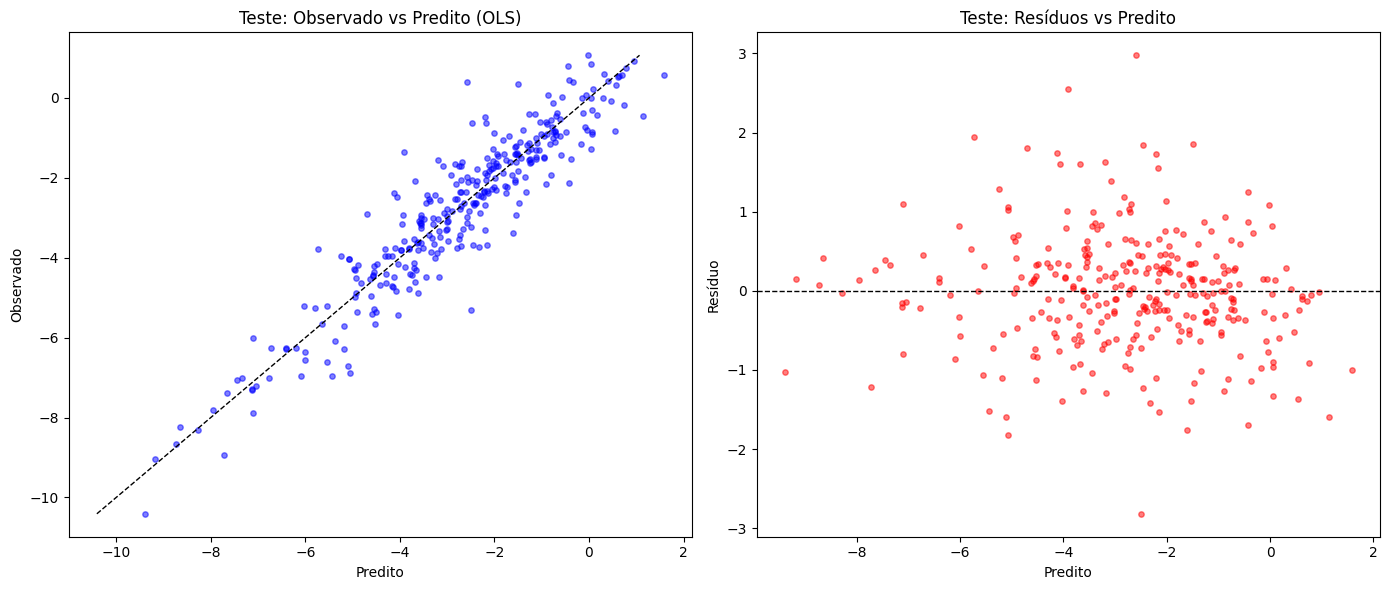

In [159]:
# usando o modelo Built-in já treinado para gerar os gráficos finais
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# gráfico 1: Observado vs Predito
ax[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
ax[0].scatter(y_pred_sklearn_test, y_test, alpha=0.5, color='blue', s=15)
ax[0].set_title("Teste: Observado vs Predito (OLS)")
ax[0].set_xlabel("Predito")
ax[0].set_ylabel("Observado")

# gráfico 2: Resíduos vs Predito
residuos = y_test - y_pred_sklearn_test
ax[1].axhline(y=0, color='black', linestyle='--', lw=1)
ax[1].scatter(y_pred_sklearn_test, residuos, alpha=0.5, color='red', s=15)
ax[1].set_title("Teste: Resíduos vs Predito")
ax[1].set_xlabel("Predito")
ax[1].set_ylabel("Resíduo")

plt.tight_layout()
plt.show()

O gráfico da esquerda temos que ele compara o valor real (observado, eixo Y) com o valor previsto pelo modelo (predito, eixo X). A linha diagonal tracejada ($y = \hat{y}$) representa o ajuste perfeito. A alta concentração dos pontos azuis ao redor da linha diagonal indica que o modelo OLS tem uma boa capacidade de generalização e que os valores previstos estão próximos dos valores reais no conjunto de teste.

O gráfico da direita diagnostica a validade dos pressupostos do modelo. a linha horizontal em $y=0$ representa o erro nulo, um cenário ideal em regressão é a dispersão aleatória e homogênea dos pontos vermelhos em torno da linha zero sem formas como funil ou U. Isso sugere que o modelo não viola o pressuposto de homocedasticidade (variância constante dos erros) e que a linearidade é uma suposição válida para este conjunto de dados.

# 4. Conclusão

No geral, o modelo OLS funcionou como esperado. A versão manual e a do scikit-learn deram exatamente os mesmos resultados, o que mostra que a implementação do zero estava correta. No conjunto de teste, o OLS apresentou valores bons de RMSE e R², indicando que ele consegue capturar parte importante da relação entre os descritores químicos e a solubilidade.

Quando usamos validação cruzada, o desempenho caiu um pouco, mostrando que o modelo varia dependendo de como os dados são divididos. Isso revela que o OLS não é totalmente estável, provavelmente por causa da colinearidade entre os preditores e pela presença de relações não lineares que o modelo não consegue capturar bem. Mesmo assim, ele serve como um ótimo ponto de partida para comparar com os outros métodos mais avançados usados no trabalho.